/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: 
The dedent

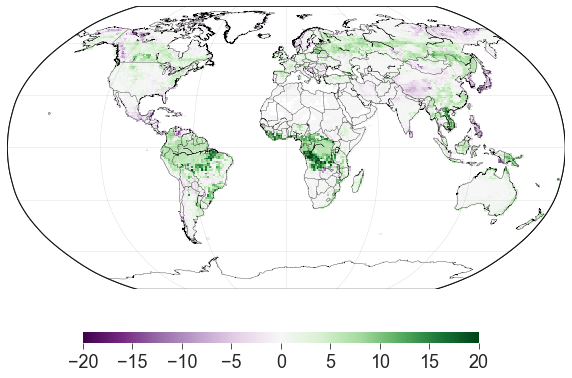

In [33]:
#!/usr/bin/env python
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from netCDF4 import Dataset
from matplotlib import cm
from mpl_toolkits.basemap import Basemap, cm
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('seaborn-ticks')

#### plot
figure_width=10
figure_length=6
figure_rows = 1
figure_cols = 1
subplot_ratio=1

def read_data(fname,var):
    pt=Dataset(fname, 'r')
    data=pt.variables[var]
    data=np.array(data)
    return data

def mask_data(data,missVal):
    data=np.where(data==missVal, np.nan,data)
    data=np.where(data>1e35, np.nan,data)
    return data

def fillmissing_lucc(data):
    data=np.where(data>=1.00001, np.nan,data)
    data=np.where(data<0.0, np.nan,data)
    return data

def fill_missingVal(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data
    
def plotmap(data,ax):
    lon_0 = np.mean(lons)
    lat_0 = np.mean(lats)
    m = Basemap(projection='robin',lon_0=lon_0,lat_0=lat_0,\
                llcrnrlat=np.amin(lats),urcrnrlat=np.amax(lats),\
                llcrnrlon=np.amin(lons),urcrnrlon=np.amax(lons),\
                rsphere=6371200.,resolution='l',area_thresh=10000,ax=ax)
    
    linewidth=0.3
    m.drawcoastlines(color='k', linewidth=linewidth)
    m.drawcountries(color='k', linewidth=linewidth)
    m.drawmapboundary(fill_color='white', zorder=-1)
    m.fillcontinents(color='0.8', lake_color='white', zorder=0)
    m.drawparallels(np.arange(-60.,91.,30.), dashes=[1,1], linewidth=0.25, color='0.5')
    m.drawmeridians(np.arange(0., 360., 60.), dashes=[1,1], linewidth=0.25, color='0.5')
    
    cmap = plt.get_cmap('PRGn')
    cmap.set_under('white')
    cmap.set_bad('white')
        
    viridisBig = plt.get_cmap('jet', 16)
    newcmp = ListedColormap(viridisBig(np.linspace(0.2, 0.4, 8)))
    mcolors = plt.cm.YlOrRd(np.linspace(0.2, 0.5, 8))
    cmap_custom = ListedColormap(mcolors)
    
    plotdata = np.vstack([m.transform_scalar(data[:, :], lons, lats, glon, glat).reshape(glat, glon)])
    lon = np.arange(-180, 180, 1.25)
    lat = np.arange(-90, 90, 0.94)
    lon, lat = np.meshgrid(lon, lat)
    lon, lat = m(lon, lat)
    cs = m.pcolormesh(lon, lat, data,  vmin=vmin, vmax=vmax, cmap=cmap, \
                      rasterized=False, edgecolor='0.6', linewidth=0,alpha = 1.0)
    
    ticks = np.arange(vmin,vmax+1,1)
    mpl.rcParams['axes.linewidth'] = border_width
    mpl.rcParams['axes.edgecolor'] = "white"
    return cs

def read_one_ensemble(caseid):
    fname=data_dir+var+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100.nc"
    data = read_data(fname, "value")
    lastyrindex = -1
    data = data[lastyrindex,:,:]-data[0,:,:]
    data=fill_missingVal(data,1e36)
    data[data==0] = np.nan
    vegc=data/1000. #convert gC/m2 to kgC/m2
    return vegc

def sub_function():    
    fig, ax = plt.subplots(figure_rows, figure_cols, figsize=(figure_width,figure_length))
    
    ### get mean values of the three ensembles
    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble(caseid)
    vegc = np.nanmean(ensbase,axis=0)
    
    cs = plotmap(vegc,ax)
    
    ### colorbar
    ticks = np.arange(vmin,vmax+step,step)
    cbaxes = fig.add_axes([0.23, 0.05, 0.55, 0.027])
    cbar = fig.colorbar(cs, cax=cbaxes, ticks=ticks, orientation='horizontal', extend='neither', \
                 spacing='proportional')
    cbar.ax.tick_params(labelsize=18)
    
#     fig_dir = "../figures/"    
#     fname=fig_dir+"Fig3a.pdf"
#     fig.savefig(fname,format='pdf',bbox_inches='tight')
    return vegc

data_dir="../data/"

ens_size=3
missVal=1e36

### for plot
vmin=-20
vmax=20
step=5

var = "TOTECOSYSC"
data = sub_function()
